<a href="https://colab.research.google.com/github/dimi1441/Biblioo/blob/master/NewTubNet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet: ReNet

## Description: ReNet est un projet dont l'idée principale est de dévélopper un modèle d'apprentissage artificiel du meme nom destiné à identifier des cas positifs et negatifs d'insuffisance rénale.

## Obejectif: Remporter la compétition organisée par Zindi Africa.

### To Do

1) Mettre à jour la librairie Pillow pour pouvoir utiliser transforms.Rotation()
2) Intégrer la validation croisée.
2) Ecrire le code qui vanous donner l'AUC
3) Montrer le graphe de complexité à Apache
4) Rendre le projet exécutable partout
5) Initialiser le dépot éventuellement
6) Faire une soumission
7) Faire du transfert learning
8) Faire une autre soumission

### Import

In [58]:
import os
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import helper
from PIL import Image
import random
from zipfile import ZipFile
!pip install -q git+https://github.com/eaedk/testing-zindi-package.git
from zindi.user import Zindian

### Loading data

In [59]:
# create a user object
my_username = "Dikam"
user = Zindian(username = my_username)

# Choose challenge
user.select_a_challenge(fixed_index=15)

# Download dataset
user.download_dataset("./input/")

# Decompress data file
file = ZipFile("./input/images.zip")
file.extractall("./input/")

Your password
>> ··········

[ 🟢 ] 👋🏾👋🏾 Welcome Dikam 👋🏾👋🏾


[ 🟢 ] You choose the challenge : cameroon-advance-analytic-ultrasound-image-challenge,
	Given ultrasounds of kidneys can you detect renal failure?.



./input/images.zip: 100%|██████████| 15.3M/15.3M [00:02<00:00, 6.59Mo/s]
./input/Train.csv: 100%|██████████| 1.58k/1.58k [00:00<00:00, 668ko/s]
./input/SampleSubmission.csv: 100%|██████████| 525/525 [00:00<00:00, 134ko/s]


### Reproductibility

In [60]:
def seed_everything(seed=46):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
seed_everything()

### Preprocessing

In [61]:
trans_crop =800
resize = 224
batch_size = 1
shuffle=True
k_folds = 3
smoothing = 0.0
num_class = 1
dir = "/content/input/"
model_folder = "/content/output/models/"
data_dir = '/content/input/CAMAIRAI BOX READY'

In [62]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.CenterCrop(trans_crop),
    transforms.Resize(resize),
    transforms.RandomRotation(40), # Invariant àde faibles rotation
    transforms.RandomHorizontalFlip(), # Invariant au miroir, il faut aussi qu'il soit invariant à l'echelle
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(trans_crop),
    transforms.Resize(resize),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [63]:
class RenaleDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform, smoothing=0.0, num_class=1, trainning=True):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.annotations["img_IDs"] = self.annotations["img_IDs"] + ".jpg"
        self.transform = transform
        self.trainning = trainning
        self.smoothing = smoothing
        self.num_class = num_class
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        img = self.transform(img)
        if self.trainning == True:
            y_label = torch.tensor(float((1 - self.smoothing)*self.annotations.iloc[index, 1] + self.smoothing/self.num_class))
            return (img, y_label)
        else:
            return img

In [64]:
# Pass transforms in here, then run the next cell to see how the transforms look
dt = RenaleDataset(data_dir, dir+"Train.csv", transform=train_transforms, smoothing=smoothing, num_class=num_class)

def dataset(dt, train_subsampler, test_subsampler):
    
    train_loader = torch.utils.data.DataLoader(
                      dt, 
                      batch_size=batch_size, sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(
                      dt,
                      batch_size=batch_size, sampler=test_subsampler)
    
    test_set = RenaleDataset(data_dir, dir+"Test.csv", transform=test_transforms, trainning=False)
    
    return train_loader, test_loader, DataLoader(dataset=test_set, shuffle=False, batch_size=batch_size)

### Visualisation

### Model

In [65]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
#resnet18 = models.resnet18(pretrained=True)
#alexnet = models.alexnet(pretrained=True)
#vgg16 = models.vgg16_bn(pretrained=True)
#vgg16.classifier = nn.Sequential(nn.Linear(vgg16.classifier[0].in_features, 1), nn.Sigmoid())
#squeezenet = models.squeezenet1_0(pretrained=True)
#densenet = models.densenet161(pretrained=True)
#inception = models.inception_v3(pretrained=True)
#googlenet = models.googlenet(pretrained=True)
#shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
#mobilenet_v2 = models.mobilenet_v2(pretrained=True)
model_ft = models.vgg11_bn(pretrained=True)
model_ft.classifier = nn.Sequential(nn.Linear(model_ft.classifier[0].in_features, 1), nn.Sigmoid())
#model_class = CNN(True, 1)

model = model_ft
model.to(device)

# Adam Optimizer with learning rate decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

# Binary cross entropy loss
criterion = torch.nn.BCELoss(size_average = True, reduction='mean')

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Train

In [66]:
# Create the directory containing the models
try:
  os.makedirs(model_folder[0:-1])
except:
  print("Directory already exist or the creation failed")

Directory already exist or the creation failed


In [67]:
def train_epoch(data_loader):
    model.train()
    train_loss = 0.0
    for inputs, labels in data_loader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        outputs = outputs.reshape(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
    return train_loss/len(data_loader.sampler)

def validation_epoch(data_loader):
    model.eval()
    valid_loss = 0.0
    for inputs, labels in data_loader:
                 
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model.forward(inputs)
        outputs = outputs.reshape(-1)
        loss = criterion(outputs, labels)
        
        valid_loss += loss.item()
    return valid_loss/len(data_loader.sampler)

In [68]:
epoch_number = 8
train_mean_loss = np.array(epoch_number*[0.0])
validation_mean_loss = np.array(epoch_number*[0.0])
lower_loss = 100
kfold = KFold(n_splits=k_folds, shuffle=True)

In [69]:
for epoch in range(epoch_number):
    print(f'EPOCH {epoch + 1}\n')
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dt)):
        print(len(train_ids))
        print(f'FOLD {fold}')
        print('--------------------------------')
        
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        
        train_loader, validation_loader, test_loader = dataset(dt, train_subsampler, test_subsampler)

        # train the model #
        train_mean_loss[epoch] = train_mean_loss[epoch] + train_epoch(train_loader)
        
        # validate the model #
        validation_mean_loss[epoch] = validation_mean_loss[epoch] + validation_epoch(validation_loader)

    #scheduler.step(train_mean_loss[0, epoch])
    scheduler.step(validation_mean_loss[epoch])
    
    train_mean_loss[epoch] = train_mean_loss[epoch]
    validation_mean_loss[epoch] = validation_mean_loss[epoch]
    
    times_tamp_time = time.strftime("%H%M%S")
    times_tamp_date = time.strftime("%d%m%Y")
    times_tamp_end = times_tamp_date + '-' + times_tamp_time + str(epoch)

    if validation_mean_loss[epoch] < lower_loss:
        lower_loss = validation_mean_loss[epoch]
        torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict(), 'best_loss': lower_loss, 'optimizer' : optimizer.state_dict()}, model_folder + 'm-' + times_tamp_end + '.pth.tar')
        print ('Epoch [' + str(epoch + 1) + '] [save] [' + times_tamp_end + '] loss= ' + str(lower_loss))
    else:
        print ('Epoch [' + str(epoch + 1) + '] [----] [' + times_tamp_end + '] loss= ' + str(lower_loss))

EPOCH 1

66
FOLD 0
--------------------------------
67
FOLD 1
--------------------------------
67
FOLD 2
--------------------------------
Epoch [1] [save] [24052021-2225480] loss= 2.1963544321809225
EPOCH 2

66
FOLD 0
--------------------------------
67
FOLD 1
--------------------------------
67
FOLD 2
--------------------------------
Epoch [2] [save] [24052021-2225591] loss= 1.4524124535140972
EPOCH 3

66
FOLD 0
--------------------------------
67
FOLD 1
--------------------------------
67
FOLD 2
--------------------------------
Epoch [3] [save] [24052021-2226102] loss= 1.0446191383610408
EPOCH 4

66
FOLD 0
--------------------------------
67
FOLD 1
--------------------------------
67
FOLD 2
--------------------------------
Epoch [4] [----] [24052021-2226213] loss= 1.0446191383610408
EPOCH 5

66
FOLD 0
--------------------------------
67
FOLD 1
--------------------------------
67
FOLD 2
--------------------------------
Epoch [5] [save] [24052021-2226314] loss= 0.7053739273344795
EPOCH

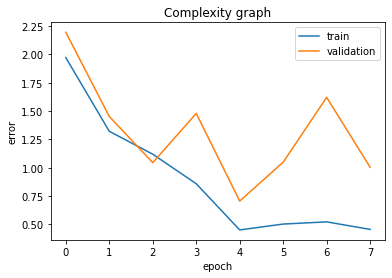

In [70]:
# Plot the complexity graph
plt.plot(train_mean_loss, label = "train")
plt.plot(validation_mean_loss, label = "validation")
plt.xlabel('epoch')
# Set the y axis label of the current axis.
plt.ylabel('error')
# Set a title of the current axes.
plt.title('Complexity graph')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [71]:
print(validation_mean_loss)
print(train_mean_loss)

[2.19635443 1.45241245 1.04461914 1.47944011 0.70537393 1.04877111
 1.62108249 1.00353811]
[1.97236567 1.32171814 1.11907744 0.85830814 0.45050728 0.50222267
 0.52167773 0.45497935]


### Eval

In [74]:
checkpoint = model_folder + "m-24052021-2226314.pth.tar"
modelCheckpoint = torch.load(checkpoint)
model.load_state_dict(modelCheckpoint['state_dict'])

<All keys matched successfully>

In [75]:
dt = RenaleDataset(data_dir, dir+"SampleSubmission.csv", transform=test_transforms, smoothing=0.0, num_class=num_class, trainning=False)
submission_loader = DataLoader(dataset=dt, shuffle=False, batch_size=batch_size)

predicted_output = torch.FloatTensor().to(device)

model.eval()

for feature in submission_loader:
    
    feature = feature.to(device)
    out = model(feature)
    predicted_output = torch.cat((predicted_output, out.data), 0)

targets = pd.read_csv(dir+"SampleSubmission.csv")
targets["target"] = predicted_output.to("cpu").numpy()
targets.to_csv(dir+"SampleSubmission.csv", index=False)